In [12]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import itertools
from sklearn.pipeline import Pipeline

In [10]:
# 导入数据
df = pd.read_csv('./OnlineNewsPopularity/OnlineNewsPopularity.csv')
keys = np.array(df.columns)
dic = {}
for colname in df:
    arr = df.loc[:,colname].values
    dic[colname] = arr
dic[keys[-1]] = dic[keys[-1]] > 1400

# 构建数据集与标签集
data_set = dic[keys[1]].reshape(-1,1)
for i in range(2,len(keys)-1):
    data_set = np.append(data_set, dic[keys[i]].reshape(-1,1), axis = 1)
label_set = dic[keys[-1]]
data_set = data_set[np.lexsort(-data_set.T[0, None])]

# 数据集划分
scaler = StandardScaler()
x_train, x_test, y_train, y_test = train_test_split(data_set, label_set, test_size=0.3, shuffle= False)
xx_train, xx_val, yy_train, yy_val = train_test_split(x_train, y_train, test_size=0.2, shuffle= False)

xx_train = scaler.fit_transform(xx_train)
xx_val = scaler.fit_transform(xx_val)

In [7]:
### 依据Fisher准则进行特征选择
J_fisher = []
feature_num = [5, 10, 20, 30, 40, 50, xx_train.shape[1]]
Model = MLPClassifier(solver= 'adam', activation= 'relu', 
        batch_size= 64, learning_rate= 'adaptive', shuffle= True,
        alpha= 0.1, hidden_layer_sizes= 50, learning_rate_init= 1e-4, max_iter=1000)

# 基于样本类别进行分类
idx_0 = np.argwhere(yy_train == False)
idx_1 = np.argwhere(yy_train == True)
X_train_0 = np.mat(xx_train[idx_0])
X_train_1 = np.mat(xx_train[idx_1])

# 基于类内类间距离的判据 and 基于最大信息系数的判据
for i in range(xx_train.shape[1]):
    mu_0 = np.mean(X_train_0[:,i])
    mu_1 = np.mean(X_train_1[:,i])
    sigma_0 = np.var(X_train_0[:,i])
    sigma_1 = np.var(X_train_1[:,i])
    J = (mu_0 - mu_1)**2/(sigma_0**2 + sigma_1**2)
    J_fisher.append(J)

In [8]:
# 根据目标特征数进行选择
for i in feature_num:
    feature_f = []
    J_f = np.argsort(J_fisher)
    feature_f = J_f[-i:]

    #计算准确率
    X_train_fselected = xx_train[:,feature_f]
    X_test_fselected = xx_val[:,feature_f]
    Model.fit(X_train_fselected, yy_train)
    Y_pred_f_v = Model.predict(X_test_fselected)
    Y_pred_f_t = Model.predict(X_train_fselected)
    acc_f_v = accuracy_score(Y_pred_f_v, yy_val)
    acc_f_t = accuracy_score(Y_pred_f_t, yy_train)

    print(str(i),"features, train acc：", acc_f_t)
    print(str(i),"features, val acc：", acc_f_v)
    print(str(i),"features index",feature_f)

5 features, train acc： 0.6077027027027027
5 features, val acc： 0.6270270270270271
5 features index [17 40 15 37 26]
10 features, train acc： 0.626981981981982
10 features, val acc： 0.6572972972972972
10 features index [ 6 36 24 13 35 17 40 15 37 26]
20 features, train acc： 0.6504054054054054
20 features, val acc： 0.6722522522522523
20 features index [27 39 18  5 29  3  2 42 16 43  6 36 24 13 35 17 40 15 37 26]
30 features, train acc： 0.6613513513513514
30 features, val acc： 0.6686486486486487
30 features index [ 8 58 32 44 51 38  1 28 56 25 27 39 18  5 29  3  2 42 16 43  6 36 24 13
 35 17 40 15 37 26]
40 features, train acc： 0.6758108108108108
40 features, val acc： 0.6724324324324324
40 features index [55 48 53 50 41 20 14 45 31 22  8 58 32 44 51 38  1 28 56 25 27 39 18  5
 29  3  2 42 16 43  6 36 24 13 35 17 40 15 37 26]
50 features, train acc： 0.69
50 features, val acc： 0.665045045045045
50 features index [57  9 30 47 19 49 33 12 10  0 55 48 53 50 41 20 14 45 31 22  8 58 32 44
 51 38 

In [11]:
feature = J_f[-40:]
x_train = x_train[:,feature]
x_test = x_test[:,feature]

In [13]:
### 模型训练

#k折分层抽样
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=233)

#实例化svm模型，网格化参数精细调参
params = {'mlp__alpha': [1e-3, 1e-2, 1e-1, 1], 'mlp__hidden_layer_sizes': [10, 20, 30, 40, 50], 'mlp__learning_rate_init': [1e-4, 1e-3, 1e-2]}
clf = Pipeline([('ss', StandardScaler()), ('mlp', MLPClassifier(solver= 'adam', activation= 'relu', batch_size= 64, learning_rate= 'adaptive', shuffle= True, max_iter= 1000))])
scores = ('accuracy', 'precision', 'f1', 'recall', 'roc_auc')
gs = GridSearchCV(clf, params, refit= 'accuracy', verbose= 1, cv= skf, scoring= scores)
gs.fit(x_train, y_train)
print('best params: ',gs.best_params_)
print('best score: ', gs.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
best params:  {'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 50, 'mlp__learning_rate_init': 0.0001}
best score:  0.6529369369369369


In [14]:
np.save('./result/mlp_cv_results_1219_60.npy', gs.cv_results_)

In [16]:
## 依次比较五项评价指标结果
res = gs.cv_results_
idx = {}

In [25]:
# 比较结果
# res = gs.cv_results_
# idx = {}

key = 'test_accuracy'
#print(res["mean_" + key])
idx[key] = np.argmax(res["mean_" + key])
for k in idx:
    print(k, res["mean_" + key][idx[k]])
    print(gs.cv_results_['params'][idx[k]])

test_accuracy 0.6529369369369369
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 50, 'mlp__learning_rate_init': 0.0001}
test_precision 0.6529369369369369
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 50, 'mlp__learning_rate_init': 0.0001}
test_f1 0.6442522522522524
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 40, 'mlp__learning_rate_init': 0.01}
test_recall 0.6442522522522524
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 40, 'mlp__learning_rate_init': 0.01}
test_roc_auc 0.6529369369369369
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 50, 'mlp__learning_rate_init': 0.0001}


In [24]:
# 比较结果
key = 'test_precision'
#print(res["mean_" + key])
idx[key] = np.argmax(res["mean_" + key])
for k in idx:
    print(k, res["mean_" + key][idx[k]])
    print(gs.cv_results_['params'][idx[k]])

test_accuracy 0.6619669021328022
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 50, 'mlp__learning_rate_init': 0.0001}
test_precision 0.6619669021328022
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 50, 'mlp__learning_rate_init': 0.0001}
test_f1 0.6375926312566954
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 40, 'mlp__learning_rate_init': 0.01}
test_recall 0.6375926312566954
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 40, 'mlp__learning_rate_init': 0.01}
test_roc_auc 0.6619669021328022
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 50, 'mlp__learning_rate_init': 0.0001}


In [23]:
# 比较结果
key = 'test_f1'
#print(res["mean_" + key])
idx[key] = np.argmax(res["mean_" + key])
for k in idx:
    print(k, res["mean_" + key][idx[k]])
    print(gs.cv_results_['params'][idx[k]])

test_accuracy 0.6567871734997899
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 50, 'mlp__learning_rate_init': 0.0001}
test_precision 0.6567871734997899
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 50, 'mlp__learning_rate_init': 0.0001}
test_f1 0.6675252629917662
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 40, 'mlp__learning_rate_init': 0.01}
test_recall 0.6675252629917662
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 40, 'mlp__learning_rate_init': 0.01}
test_roc_auc 0.6567871734997899
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 50, 'mlp__learning_rate_init': 0.0001}


In [22]:
# 比较结果
key = 'test_recall'
#print(res["mean_" + key])
idx[key] = np.argmax(res["mean_" + key])
for k in idx:
    print(k, res["mean_" + key][idx[k]])
    print(gs.cv_results_['params'][idx[k]])

test_accuracy 0.6517680339462517
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 50, 'mlp__learning_rate_init': 0.0001}
test_precision 0.6517680339462517
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 50, 'mlp__learning_rate_init': 0.0001}
test_f1 0.7012729844413013
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 40, 'mlp__learning_rate_init': 0.01}
test_recall 0.7012729844413013
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 40, 'mlp__learning_rate_init': 0.01}
test_roc_auc 0.6517680339462517
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 50, 'mlp__learning_rate_init': 0.0001}


In [21]:
# 比较结果
key = 'test_roc_auc'
#print(res["mean_" + key])
idx[key] = np.argmax(res["mean_" + key])
for k in idx:
    print(k, res["mean_" + key][idx[k]])
    print(gs.cv_results_['params'][idx[k]])

test_accuracy 0.7078663090933844
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 50, 'mlp__learning_rate_init': 0.0001}
test_precision 0.7078663090933844
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 50, 'mlp__learning_rate_init': 0.0001}
test_f1 0.6987104913913245
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 40, 'mlp__learning_rate_init': 0.01}
test_recall 0.6987104913913245
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 40, 'mlp__learning_rate_init': 0.01}
test_roc_auc 0.7078663090933844
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 50, 'mlp__learning_rate_init': 0.0001}


In [27]:
### 模型预测
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
model1 = MLPClassifier(solver= 'adam', activation= 'relu', batch_size= 64, learning_rate= 'adaptive', shuffle= True, max_iter= 1000,
                alpha= 0.1, hidden_layer_sizes= 50, learning_rate_init= 1e-4)
model1.fit(x_train, y_train)
y_pred1 = model1.predict(x_test)

In [30]:
# 绘制混淆矩阵
def plot_confusion_matrix(cm, labels_name, title):
    plt.figure(figsize=(15,8),dpi=100)
    plt.subplot(1,2,1)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        num = '{}'.format(cm[i, j])
        plt.text(j, i, num,
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white" if int(num) > thresh else "black")
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')

    
    plt.subplot(1,2,2)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        num = '{:.2f}'.format(cm[i, j])
        plt.text(j, i, num,
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white" if float(num) > thresh else "black")
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')
# 混淆矩阵绘制代码来源以下两篇博客：
# https://blog.csdn.net/kane7csdn/article/details/83756583
# https://blog.csdn.net/qq_18617009/article/details/103345308

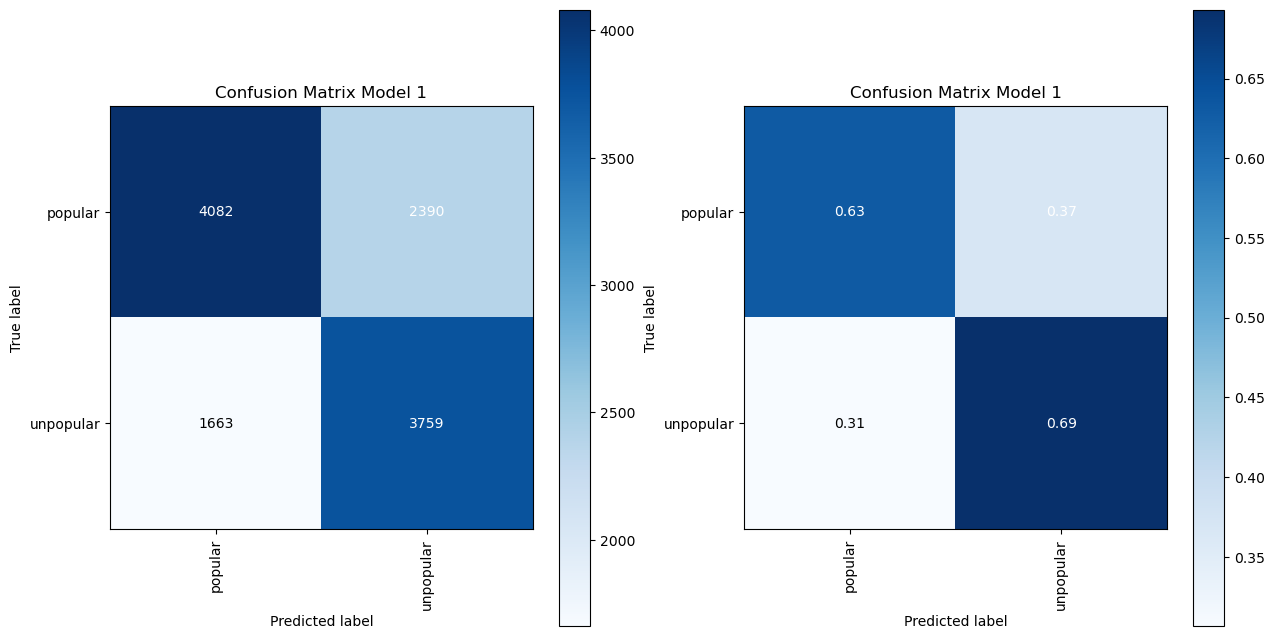

acc: 0.6592399529174373
pre: 0.6113189136444951
recall: 0.6932866101069716
f1: 0.6497277676950999
AUCf1: 0.6620017722969963


In [31]:
# 结果可视化
cm = confusion_matrix(y_test, y_pred1)
labels_name = ['popular','unpopular']
plot_confusion_matrix(cm, labels_name, "Confusion Matrix Model 1")
plt.show()
print("acc: " + str(accuracy_score(y_test, y_pred1)))
print("pre: " + str(precision_score(y_test, y_pred1)))
print("recall: " + str(recall_score(y_test, y_pred1)))
print("f1: " + str(f1_score(y_test, y_pred1)))
print("AUCf1: " + str(roc_auc_score(y_test, y_pred1)))